### 4.1 Contents<a id='4.1_Contents'></a>

  * [4.2 Load The Data](#4.2_Load_The_Data)      
  * [4.3 Future forcast](#4.3_Future_forcast)
  * [4.4 AutoML mljar](#4.4_AutoML_mljar)
  * [4.5 Summary](#4.5_Summary)
  

[<a href="#4.1_Contents">Back to top</a>] 

In [1]:
import pandas as pd
import pickle
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt

### 4.2  Load The Data<a id='4.2_Load_The_Data'></a>     

In [2]:
train_df= pd.read_pickle("./Data/train.pkl")
test_df = pd.read_pickle("./Data/test.pkl")

In [3]:
display(train_df.tail(3), test_df.head(3),test_df.tail(3))

,Call count
Date,
2021-04-30,241648
2021-05-31,274411
2021-06-30,301378


,Call count
Date,
2021-07-31,303152
2021-08-31,282244
2021-09-30,317507


,Call count
Date,
2022-10-31,267062
2022-11-30,246526
2022-12-31,260642


### 4.3  Future forcast<a id='4.3_Future_forcast'></a>     

[<a href="#4.1_Contents">Back to top</a>] 

C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Text(0.5, 1.0, 'SARIMA predicted Calls')

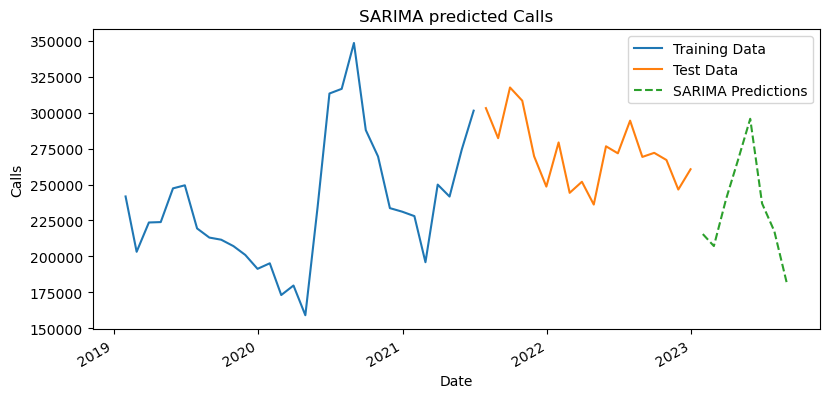

In [4]:
model_SARIMA = SARIMAX(train_df["Call count"], order=(1, 1, 1), seasonal_order=(0, 1, 0, 11))
model_SARIMA_fit = model_SARIMA.fit()
pred_dates = pd.date_range(start="2023-01-31", end="2023-08-31", freq="M")
pred_df = pd.DataFrame({'Date': pred_dates, 'calls': model_SARIMA_fit.predict(start=pred_dates[0], end=pred_dates[-1])})
pred_df.set_index('Date', inplace=True)

fig, ax1 = plt.subplots(figsize=(8, 4))
fig.tight_layout()
fig.autofmt_xdate()

# plot the training data, testing data, and predictions
ax1.set_xlabel("Date")
ax1.set_ylabel("Calls")
ax1.plot(train_df["Call count"], label="Training Data")
ax1.plot(test_df["Call count"], label="Test Data")
ax1.plot(pred_df ['calls'], label="SARIMA Predictions", ls='--')
ax1.legend()
ax1.set_title("SARIMA predicted Calls")

### 4.4  AutoML mljar<a id='4.4_AutoML_mljar'></a>     

[<a href="#4.1_Contents">Back to top</a>] 

In [5]:
from supervised.automl import AutoML

# Load your time series data into train_df and test_df
# Assuming 'Call count' is the column with call counts and 'Date' is the index

# Create a lagged version of the time series data as additional features
def create_lagged_features(data, lag):
    for i in range(1, lag+1):
        data[f'Call count Lag-{i}'] = data['Call count'].shift(i)
    return data.dropna()

lag = 11  # Choose the lag for the lagged features
train_lagged = create_lagged_features(train_df, lag)
test_lagged = create_lagged_features(test_df, lag)

# Prepare data for AutoML
X_train = train_lagged.drop('Call count', axis=1)
y_train = train_lagged['Call count']
X_test = test_lagged.drop('Call count', axis=1)
y_test = test_lagged['Call count']

# Initialize and train AutoML
automl = AutoML(mode='Compete')
automl.fit(X_train, y_train)

# Make predictions using AutoML
predictions = automl.predict(X_test)

# Evaluate AutoML model
rmse = ((predictions - y_test) ** 2).mean() ** 0.5
print(f"Root Mean Squared Error (RMSE): {rmse}")

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


AutoML directory: AutoML_2
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Decision Tree', 'Linear', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble available models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 2.334817 trained in 0.61 seconds
Adjust validation. Remove: 1_DecisionTree
*** Disable stacking for small dataset (nrows < 500)
Validation strategy: 10-fold CV Shuffle,Stratify
* Step simple_algorithms will try to check up to 4 models
1_DecisionTree logloss 2.334817 trained in 1.96 seconds
2_DecisionTree logloss 2.1379

C:\Users\asiya\anaconda3\envs\cp3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


* Step boost_on_errors will try to check up to 1 model
72_LightGBM_BoostOnErrors logloss 4.3e-05 trained in 20.29 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 1.8e-05 trained in 17.12 seconds
AutoML fit time: 3488.51 seconds
AutoML best model: 11_Default_NearestNeighbors
Root Mean Squared Error (RMSE): 40212.89975510701


### 4.5  Summary<a id='4.5_Summary'></a>     


In this notebook, I employed the Seasonal Autoregressive Integrated Moving Average (SARIMA) model to project the volume of incoming calls over the upcoming 7 months (January 2023 to July 2023). Subsequently, I leveraged a sophisticated tool known as "mljar-supervised," capable of conducting simultaneous experimentation with various models including Random Forest, Gradient Boosting, and more.

The standout outcome from this tool was (AutoML best model): "11_Default_NearestNeighbors." While not flawless, it emerged as the most promising candidate among all the models evaluated, yielding a prediction with a Root Mean Squared Error (RMSE) of 40212.89.

Interestingly, our conventional SARIMA approach continued to demonstrate its efficacy. It generated a prediction with an RMSE of approximately 20161.45 and showcased the lowest Mean Absolute Percentage Error (MAPE) of 0.060617.

The collective projections from the models assessed collectively indicate a declining trend in call volume for 2023 compared to the figures recorded in 2022.

[<a href="#4.1_Contents">Back to top</a>] 